# Interpolating wind and pressure to grids using station observations

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as feat

from metpy.mapping.map_functions import interpolate
from metpy.cbook import get_test_data
from metpy.calc import get_wind_components
from metpy.units import units
from metpy.plots import StationPlot

from scipy.ndimage.filters import gaussian_filter

from_proj = ccrs.Geodetic()
to_proj = ccrs.AlbersEqualArea(central_longitude=-97.0000, central_latitude=38.0000)

plt.rcParams['figure.figsize'] = 20,15
warnings.filterwarnings('ignore')

In [2]:
def make_string_list(arr):
    return [s.decode('ascii') for s in arr]

def station_test_data(variable_names, proj_from=None, proj_to=None):

    f = get_test_data('station_data.txt')

    all_data = np.loadtxt(f, skiprows=1, delimiter=',',
                          usecols=(1, 2, 3, 4, 5, 6, 7, 17, 18, 19),
                          dtype=np.dtype([('stid', '3S'), ('lat', 'f'), ('lon', 'f'),
                                          ('slp', 'f'), ('air_temperature', 'f'),
                                          ('cloud_fraction', 'f'), ('dewpoint', 'f'),
                                          ('weather', '16S'),
                                          ('wind_dir', 'f'), ('wind_speed', 'f')]))

    all_stids = make_string_list(all_data['stid'])

    data = np.concatenate([all_data[all_stids.index(site)].reshape(1, ) for site in all_stids])

    value = data[variable_names]
    lon = data['lon']
    lat = data['lat']

    # lon = lon[~np.isnan(value)]
    # lat = lat[~np.isnan(value)]
    # value = value[~np.isnan(value)]

    if proj_from is not None and proj_to is not None:

        try:

            proj_points = proj_to.transform_points(proj_from, lon, lat)
            return proj_points[:, 0], proj_points[:, 1], value

        except Exception as e:

            print(e)
            return None

    return lon, lat, value

Get pressure information using the sample station data

In [3]:
xp, yp, pres = station_test_data(['slp'], from_proj, to_proj)

Remove all missing data from pressure

In [4]:
pres = np.array([x[0] for x in pres])

good_obs = [~np.isnan(pres)]

xp = xp[good_obs]
yp = yp[good_obs]
pres = pres[good_obs]

Interpolate pressure as usual

In [5]:
slpgridx, slpgridy, slp = interpolate(xp, yp, pres, interp_type="cressman", minimum_neighbors=1, 
                                      search_radius = 500000, hres=100000)

Get wind information

In [6]:
x, y, wind = station_test_data(['wind_speed', 'wind_dir'], from_proj, to_proj)

Remove bad data from wind information

In [7]:
wind_speed = np.array([w[0] for w in wind])
wind_dir = np.array([w[1] for w in wind])

good_indices = np.where((~np.isnan(wind_dir)) & (~np.isnan(wind_speed)))

x = x[good_indices]
y = y[good_indices]
wind_speed = wind_speed[good_indices]
wind_dir = wind_dir[good_indices]

Calculate u and v components of wind and then interpolate both.

Both will have the same underlying grid so throw away grid returned from v interpolation.

In [8]:
u, v = get_wind_components((wind_speed * units('m/s')).to('knots'),
                            wind_dir * units.degree)

windgridx, windgridy, uwind = interpolate(x, y, np.array(u), interp_type="cressman", search_radius = 400000, hres=100000)
_, _, vwind = interpolate(x, y, np.array(v), interp_type="cressman", search_radius = 400000, hres=100000)


Set up the map and plot the interpolated grids appropriately.

<a list of 11 text.Text objects>

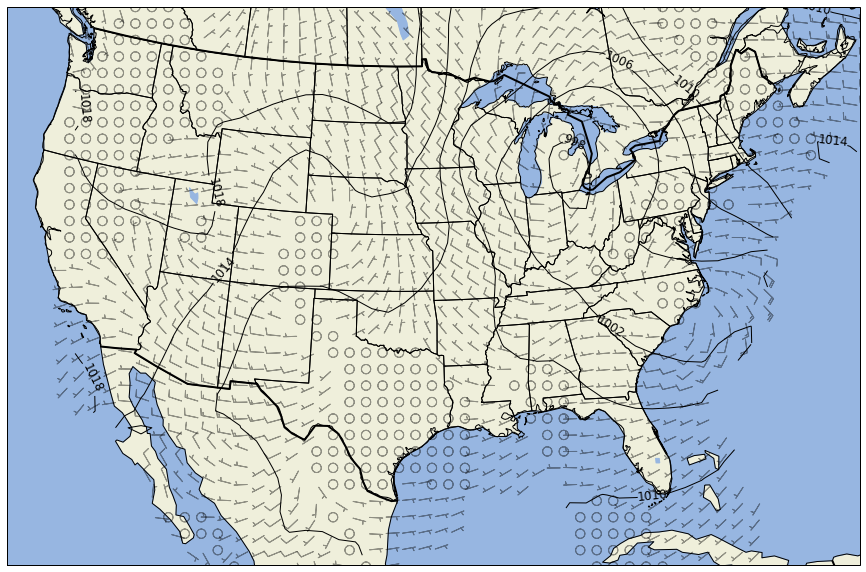

In [9]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=to_proj)

ax.add_feature(feat.LAND, zorder=-1)
ax.add_feature(feat.OCEAN, zorder=-1)
ax.add_feature(feat.LAKES, zorder=-1)
ax.coastlines(resolution='110m', zorder=2, color='black')
ax.add_feature(feat.NaturalEarthFeature(
                                category='cultural',
                                name='admin_1_states_provinces_lakes',
                                scale='50m',
                                facecolor='none'))
ax.add_feature(feat.BORDERS, linewidth='2', edgecolor='black')

ax.set_extent((-120, -70, 20, 50))

stationplot = StationPlot(ax, windgridx, windgridy, fontsize=7)

stationplot.plot_barb(uwind, vwind, alpha=.4)

cs = ax.contour(slpgridx, slpgridy, slp, colors=['k',], levels=list(range(990, 1034, 4)))

plt.clabel(cs, inline=1, fontsize=12, fmt='%i')